In [1]:
from fastai.vision.all import *
from fastai.vision.utils import *

In [2]:
path = './imgs'

In [3]:
shoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

In [4]:
dls = shoes.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [5]:
shoes = shoes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = shoes.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\dhruv\anaconda3\lib\site-packages\torch\_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


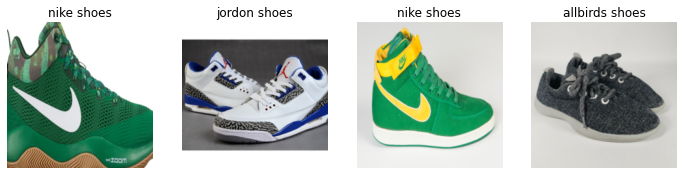

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

# Train Plain ResNet18

In [7]:
res18 = cnn_learner(dls, resnet18, metrics=error_rate)

C:\Users\dhruv\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


C:\Users\dhruv\anaconda3\lib\site-packages\fastai\callback\schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


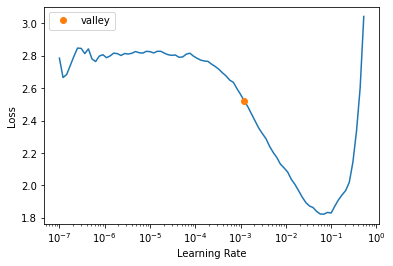

In [8]:
lr = res18.lr_find()

In [9]:
res18.fine_tune(4, base_lr=lr.valley, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time
0,1.893943,0.734334,0.254167,01:10


Better model found at epoch 0 with valid_loss value: 0.7343337535858154.


epoch,train_loss,valid_loss,error_rate,time
0,0.862292,0.478958,0.147917,01:12
1,0.633605,0.276547,0.087500,01:12
2,0.452370,0.217688,0.054167,01:11
3,0.358464,0.214993,0.054167,01:11


Better model found at epoch 0 with valid_loss value: 0.4789581596851349.
Better model found at epoch 1 with valid_loss value: 0.27654650807380676.
Better model found at epoch 2 with valid_loss value: 0.21768823266029358.
Better model found at epoch 3 with valid_loss value: 0.2149927169084549.


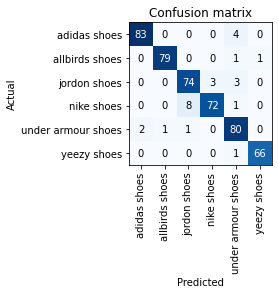

In [10]:
interp = ClassificationInterpretation.from_learner(res18)
interp.plot_confusion_matrix()

# Train ResNet18 with RandomErasing

In [15]:
shoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))
dls = shoes.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [36]:
shoes = shoes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=[*aug_transforms(xtra_tfms=[RandomErasing(1, min_aspect=0.3, sh=0.1, max_count=5)])])
dls = shoes.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


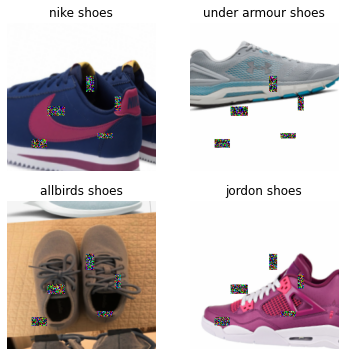

In [37]:
dls.train.show_batch(max_n=4)

In [38]:
res18_noise = cnn_learner(dls, resnet18, metrics=error_rate)

C:\Users\dhruv\anaconda3\lib\site-packages\fastai\callback\schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


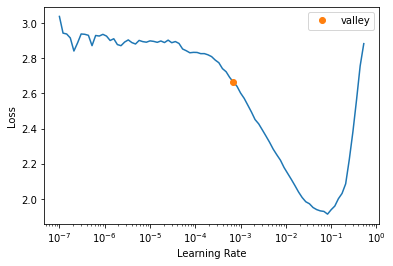

In [39]:
lr = res18_noise.lr_find()

In [40]:
res18_noise.fine_tune(4, base_lr=lr.valley, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,error_rate,time
0,2.187488,0.918846,0.341667,01:09


Better model found at epoch 0 with valid_loss value: 0.9188461899757385.


epoch,train_loss,valid_loss,error_rate,time
0,1.246764,0.712504,0.235417,01:14
1,1.037964,0.509497,0.168750,01:12
2,0.841898,0.434308,0.122917,01:11
3,0.715417,0.423923,0.133333,01:11


Better model found at epoch 0 with valid_loss value: 0.7125042080879211.
Better model found at epoch 1 with valid_loss value: 0.509497344493866.
Better model found at epoch 2 with valid_loss value: 0.43430832028388977.
Better model found at epoch 3 with valid_loss value: 0.4239234924316406.


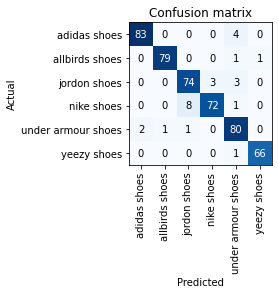

In [41]:
interp = ClassificationInterpretation.from_learner(res18)
interp.plot_confusion_matrix()

# Create Ensemble with 2 models and get predictions

In [42]:
class Ensemble:
  def __init__(self, dl, models : dict, vocab : list = [0, 1]):
    self.models = models
    self.vocab = vocab
    self.dl = dl
    print(f'vocab: {self.vocab}')
    for name, model in models.items():
      print(f'loaded: {name}')


  def calc_probas(self, item):
    probas = []
    for _, model in self.models.items():
      _, _, p = model.predict(item)
      probas.append(p)
    
    probas = torch.stack(probas, dim=0)
    return probas

  def predict(self, item):
    probas = self.calc_probas(item)
    mean, std = probas.mean(axis=0), probas.std(axis=0)

    return self.vocab[mean.argmax()], mean, std
  
  def get_preds(self, dl=None, with_input=True, with_loss=True, with_decoded=True, act=None):
    if dl is None: dl = self.model_list[0].dls[1]
    predictions = []
    losses = []
    for name, model in self.models.items():
      print(f'Getting predictions from {name}')
      inputs, preds, targs, decoded, loss = model.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)
      predictions.append(preds)
      losses.append(loss)
    
    preds = torch.stack(predictions).mean(0)
    decoded = preds.argmax(1)
    return inputs, preds, targs, decoded, torch.stack(losses, dim=1).mean(1)

  def calc_metrics(self, metrics : dict):
    res = {}
    _,_, targs, decoded,_ = self.get_preds(self.dl)
    for name, metric in metrics.items():
      res[name] = metric(decoded, targs)
    return res

In [43]:
en = Ensemble(dls.valid, {'res18': res18, 'res18_noise': res18_noise}, vocab=dls.valid.vocab)

vocab: ['adidas shoes', 'allbirds shoes', 'jordon shoes', 'nike shoes', 'under armour shoes', 'yeezy shoes']
loaded: res18
loaded: res18_noise


In [53]:
en.calc_metrics({'F1Score': F1Score(average=None)})

Getting predictions from res18


Getting predictions from res18_noise


{'F1Score': array([0.95348837, 0.97530864, 0.90123457, 0.92307692, 0.91860465,
        0.97058824])}

In [45]:
inputs, predictions, targs, decoded, losses = en.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True, act=None)

Getting predictions from res18


Getting predictions from res18_noise


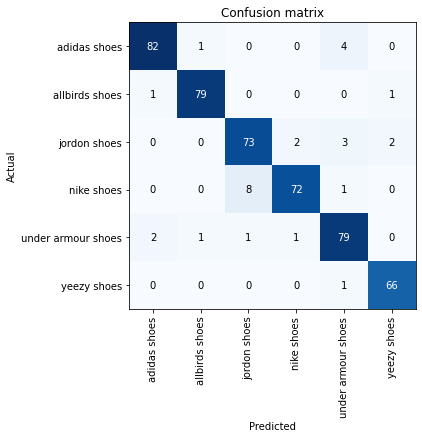

In [46]:
# interp = ClassificationInterpretation.from_learner(en, dl=dls.valid) -> calls get_preds
interp = ClassificationInterpretation(dls.valid, inputs, predictions, targs, decoded, losses)
interp.plot_confusion_matrix(figsize=(6,6))

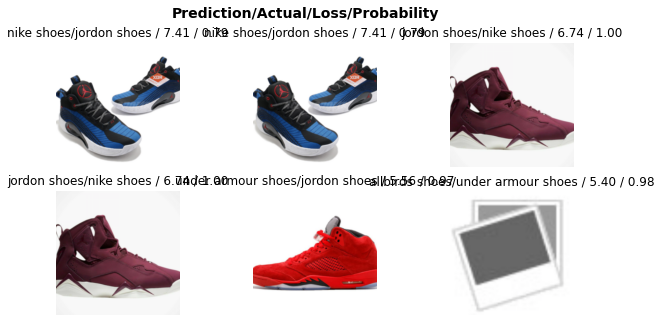

In [47]:
interp.plot_top_losses(6, figsize=(10,5))